## IMPORTS

In [37]:
import cv2
import numpy as np
import pandas as pd
SEED =12
def load_labels(label_file):
    """Loads image filenames, classes, and bounding boxes"""
    fnames, classes, bboxes = [], [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            fnames.append(fname)
            classes.append(int(cls))
            bboxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))
    fnames = ["/kaggle/input/covidxct/3A_images/" + fname for fname in fnames]
    fnames = np.array(fnames)
    classes = np.array(classes)
    return fnames, classes, bboxes

def index_generator(fnames , SET):
    """Genrated random index of a particular class"""
    np.random.seed(SEED)
    index = np.random.randint(1,len(fnames),size = SET)
    return index 

def numberofclasses(classes, index):
    class0 = len((np.where(classes[index]==0))[0])
    class1 = len((np.where(classes[index]==1))[0])
    class2 = len((np.where(classes[index]==2))[0])
    return class0  , class1, class2
def dataframe_generator(train_index , valid_index , classes_train , classes_valid ):
    """Returns 1 dataframes of datasets distribution"""
    index = ["Normal" , "Pneumonia" , "COIVD -19"]
    train_DF = numberofclasses(classes_train, train_index)
    valid_DF = numberofclasses(classes_valid, valid_index)
    df = pd.DataFrame({'train': train_DF ,'valid' : valid_DF} , index = index)
    return df
def train_index_updater(classes_train , train_index ):
    """Updates train_index for class balance"""
    np.random.seed(SEED)
    class0_train = np.where(classes_train[train_index]==0)[0]
    class1_train = np.where(classes_train[train_index]==1)[0]
    class2_train = np.where(classes_train[train_index]==2)[0]
    class0 =train_index[class0_train]
    class1 = train_index[class1_train]
    train_index_updated = np.concatenate((class0 , class1 ))
    np.random.shuffle(train_index_updated)
    return train_index_updated
def valid_index_updater(classes_valid , valid_index ):
    """Updates valid_index for class balance"""
    np.random.seed(SEED)
    class0_valid = np.where(classes_valid[valid_index]==0)[0]
    class1_valid = np.where(classes_valid[valid_index]==1)[0]
    class2_valid = np.where(classes_valid[valid_index]==2)[0]
    class0 =valid_index[class0_valid]
    class1 = valid_index[class1_valid]
    valid_index_updated = np.concatenate((class0 , class1))
    np.random.shuffle(valid_index_updated)
    return valid_index_updated

def data_constructor(filepath, classes , dim_size ,index  ,bboxes , interpolation = cv2.INTER_AREA , intensify =False):
    """Constructs and splits X and Y for training , validtion and test"""
    np.random.seed(SEED)
    y = np.array(classes[index])
    x = []
    for i in index:
        img  = cv2.imread(filepath[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x1,y1,x2,y2 = bboxes[i]
        img = img[y1:y2,x1:x2]
        img = cv2.resize(img, dim_size , interpolation = interpolation)
        x.append(img)
    
    x = np.array(x)
    if intensify == True:
        x= x/255
    return x , y

In [38]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

## SETTING UP PARAMETERS AND DIRECTORIES

In [39]:
SEED = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
DIM = (IMG_HEIGHT, IMG_WIDTH)
TRAIN_SET= 53778
VALID_SET= 6486
EPOCHS = 15
BS = 32
LR = 0.01
label_file_train = "/kaggle/input/covidxct/train_COVIDx_CT-3A.txt"
label_file_valid = "/kaggle/input/covidxct/val_COVIDx_CT-3A.txt"

## LOADING DATA

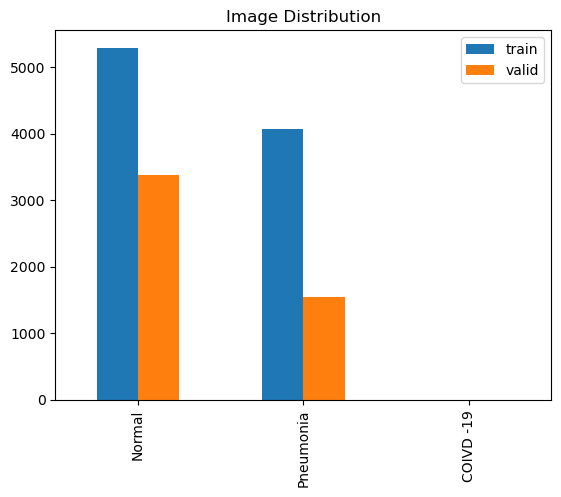

In [40]:
fnames_train , classes_train ,bboxes_train = load_labels(label_file_train)
fnames_valid , classes_valid ,bboxes_valid = load_labels(label_file_valid)
train_index = index_generator(fnames_train , TRAIN_SET)
valid_index = index_generator(fnames_valid , VALID_SET)
train_index_updated = train_index_updater(classes_train,train_index )
valid_index_updated = valid_index_updater(classes_valid, valid_index)
df = dataframe_generator(train_index_updated , valid_index_updated , classes_train , classes_valid)
df.plot.bar( title = "Image Distribution" );

## Loading Training and Validation Images

In [41]:
x_train, y_train = data_constructor(fnames_train,classes_train, DIM , index  =train_index_updated , bboxes = bboxes_train )
x_valid , y_valid= data_constructor(fnames_valid,classes_valid, DIM , index  =valid_index_updated , bboxes = bboxes_valid )

## Pre-Processing

In [42]:
x_train = tf.keras.applications.inception_v3.preprocess_input(x_train)
x_valid = tf.keras.applications.inception_v3.preprocess_input(x_valid)

In [43]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,zoom_range=0.1,width_shift_range=0.1 ,height_shift_range=0.05,shear_range=0.05)
train_generator = data_generator.flow(x_train, y_train, BS)
spe = x_train.shape[0] // BS

## MODEL DESIGN

In [44]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [45]:
base_model = InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
model= tf.keras.Sequential()
model.add(base_model) 
model.add(GlobalAveragePooling2D())
model.add(Dense(128,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(1,activation=('sigmoid')))

## MODEL SUMMARY

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_____________________________________

## MODEL COMPILATION

In [47]:
model.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

## CALLBACKS

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

## MODEL TRAINING

In [49]:
r = model.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS, callbacks = [checkpoint] )

Epoch 1/15
292/292 [==============================] - 67s 179ms/step - loss: 0.2354 - accuracy: 0.8991 - val_loss: 0.0787 - val_accuracy: 0.9730
Epoch 2/15
292/292 [==============================] - 49s 166ms/step - loss: 0.0949 - accuracy: 0.9683 - val_loss: 0.0971 - val_accuracy: 0.9697
Epoch 3/15
292/292 [==============================] - 48s 164ms/step - loss: 0.0633 - accuracy: 0.9772 - val_loss: 0.0788 - val_accuracy: 0.9681
Epoch 4/15
292/292 [==============================] - 50s 171ms/step - loss: 0.0579 - accuracy: 0.9819 - val_loss: 0.0531 - val_accuracy: 0.9831
Epoch 5/15
292/292 [==============================] - 49s 169ms/step - loss: 0.0437 - accuracy: 0.9858 - val_loss: 0.0556 - val_accuracy: 0.9829
Epoch 6/15
292/292 [==============================] - 51s 175ms/step - loss: 0.0316 - accuracy: 0.9896 - val_loss: 0.0379 - val_accuracy: 0.9862
Epoch 7/15
292/292 [==============================] - 50s 170ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 0.0448 - val_ac

## TRAINING PLOTS

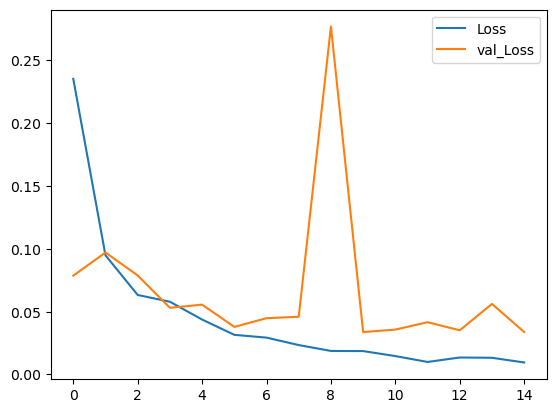

In [50]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

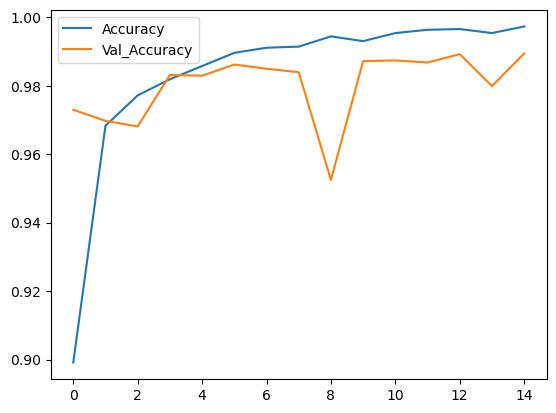

In [51]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

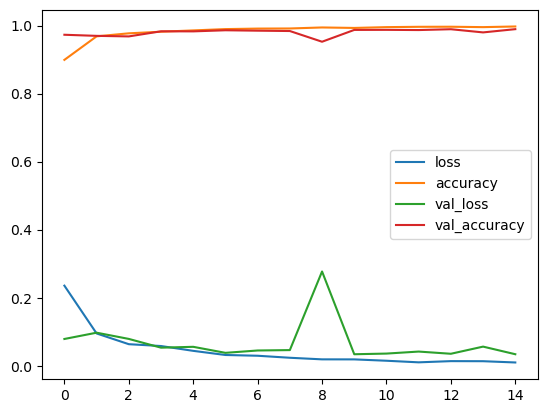

In [52]:
pd.DataFrame(r.history).plot();

In [53]:
pd.DataFrame(r.history).to_csv("inception.csv",index=False)

## SAVING TRAINED MODEL

In [54]:
model.save("Inception.h5")